In [18]:
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import torch
import matplotlib.pyplot as plt

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
n_samples = 1000
X, y = make_moons(
    n_samples=n_samples,
    random_state=42,
    noise=1.5
)
X[:10], y[:10]

(array([[-0.89422583,  1.50855016],
        [ 2.58087765,  0.66055225],
        [-0.14478285,  3.1525602 ],
        [-2.18948947, -1.89434932],
        [-0.59581811,  0.66020814],
        [ 1.29696728,  1.96981844],
        [ 0.11870341, -0.04205537],
        [-0.88842664,  1.30073902],
        [ 1.15834696, -0.75022124],
        [ 1.4705179 ,  2.30775604]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

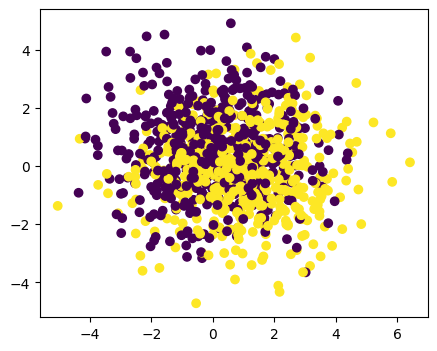

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

plt.figure(figsize=(5, 4))
plt.scatter(X[:, 0], X[:, 1], c=y)

In [22]:
X_train = torch.from_numpy(X_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
y_test = torch.from_numpy(y_test).type(torch.float).to(device)

In [23]:
class Model(nn.Module):
    def __init__(self, hidden_size=15, single_num_hidden=5):
        super().__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=hidden_size)
        self.relu = nn.ReLU()
        self.hidden_layers = nn.Sequential(
            *[nn.Sequential(nn.Linear(in_features=hidden_size, out_features=hidden_size), nn.ReLU()) for _ in range(single_num_hidden)]
        )
        self.out = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, x):
        out1 = self.relu(self.linear1(x))
        out2 = self.hidden_layers(out1) + out1
        out3 = self.hidden_layers(out2) + out2
        res = self.out(out3)
        return res
        
    

model = Model().to(device)
model

Model(
  (linear1): Linear(in_features=2, out_features=15, bias=True)
  (relu): ReLU()
  (hidden_layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=15, out_features=15, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=15, out_features=15, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=15, out_features=15, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=15, out_features=15, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=15, out_features=15, bias=True)
      (1): ReLU()
    )
  )
  (out): Linear(in_features=15, out_features=1, bias=True)
)

In [24]:
y_preds = model(X_test)
y_preds[:5], y_test[:5]

(tensor([[0.2891],
         [0.7488],
         [0.8859],
         [1.2264],
         [0.1404]], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([1., 0., 1., 0., 1.], device='cuda:0'))

In [25]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [26]:
def accuracy_fn(y_preds, y_true):
    res = torch.eq(y_preds.squeeze(), y_true).sum().item()
    return 100 * res / len(y_true)

In [27]:
epochs = 100000
losses = []

for epoch in range(epochs):
    model.train()

    y_logits = model(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    acc = accuracy_fn(y_preds=y_preds, y_true=y_train)
    loss = loss_fn(y_logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss)

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_acc = accuracy_fn(test_preds, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Training Loss: {loss:.4f} | Training Acc: {acc:.2f}% | Testing Acc: {test_acc:.2f}%")

Epoch: 0 | Training Loss: 0.7119 | Training Acc: 53.00% | Testing Acc: 53.50%
Epoch: 100 | Training Loss: 0.6539 | Training Acc: 63.50% | Testing Acc: 63.00%
Epoch: 200 | Training Loss: 0.6367 | Training Acc: 65.00% | Testing Acc: 64.50%
Epoch: 300 | Training Loss: 0.6280 | Training Acc: 65.62% | Testing Acc: 64.00%
Epoch: 400 | Training Loss: 0.6235 | Training Acc: 66.00% | Testing Acc: 63.50%
Epoch: 500 | Training Loss: 0.6212 | Training Acc: 66.00% | Testing Acc: 63.00%
Epoch: 600 | Training Loss: 0.6199 | Training Acc: 66.12% | Testing Acc: 63.00%
Epoch: 700 | Training Loss: 0.6192 | Training Acc: 66.38% | Testing Acc: 63.00%
Epoch: 800 | Training Loss: 0.6188 | Training Acc: 66.38% | Testing Acc: 63.00%
Epoch: 900 | Training Loss: 0.6185 | Training Acc: 66.12% | Testing Acc: 62.50%
Epoch: 1000 | Training Loss: 0.6183 | Training Acc: 66.00% | Testing Acc: 62.50%
Epoch: 1100 | Training Loss: 0.6181 | Training Acc: 66.25% | Testing Acc: 62.50%
Epoch: 1200 | Training Loss: 0.6180 | Tr

In [29]:
model.eval()
with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_acc = accuracy_fn(test_preds, y_test)

print(test_acc)

58.0
